In [1]:
from quadratic_monte_carlo import QMCSampler
from state import QMCState, set_up_starting_guesses
import numpy as np
import matplotlib.pyplot as plt
from blocking_analysis import Blocking
import emcee

In [2]:
# define log probability functions here
R = 1.
m = 6.
ndim = 6
m2 = 2 * m


def ring_lnp(params):
    rho = np.sqrt(params[0] ** 2 + params[1] ** 2)
    v = pow(m2 * (rho - R), m2)
    i = 2
    while i < ndim:
        v += pow(m2 * params[i], m2)
        i += 1
    v -= 0.01 * params[0]
    return -v / 0.01


A = np.array([R, 0, 0, 0, 0, 0])
B = np.array([-R, 0, 0, 0, 0, 0])
As = []
Bs = []

for i in range(20):
    As.append(A)
    Bs.append(B)
As = np.array(As)
Bs = np.array(Bs)


def rosenbrock_lnL(params):
    x1, x2 = params
    lnL = ((-100 * pow((x2 - pow(x1, 2)), 2)) + pow((1 - x1), 2)) / 20
    return lnL


def harmonic_lnp(params):
    n = len(params)
    v = 0
    for j in range(n):
        v += params[j] * params[j]
    return -(v / 0.01)

In [3]:
qmc_trace_harmonic = []
harmonic_state = QMCState(6, harmonic_lnp, np.zeros(6)) # setup the QMCState

for i in range(1):
    # Here we'll set up the computation. emcee combines multiple "walkers",
    # each of which is its own MCMC chain. The number of trace results will
    # be nwalkers * nsteps

    ndim = 6  # number of parameters in the model
    nwalkers = 20  # number of MCMC walkers
    nburn = 5000  # "burn-in" period to let chains stabilize
    nsteps = 10000  # number of MCMC steps to take

    # set theta near the maximum likelihood randomly
    sg = np.random.random((nwalkers, ndim))
    starting_guesses = set_up_starting_guesses(harmonic_state, sg)

    # Here's the function call where all the work happens:

    sampler = QMCSampler(nwalkers, harmonic_state)
    sampler.run_qmc(starting_guesses, nsteps)

    qmc_trace_harmonic.append(sampler.chain[nburn:, :])

qmc_trace_harmonic = np.array(qmc_trace_harmonic)

In [4]:
def harmonic_potential(params):
    n = len(params)
    v = 0
    for j in range(n):
        v += params[j] * params[j]
    return v

In [5]:
print(np.shape(qmc_trace_harmonic))

(1, 5000, 20)


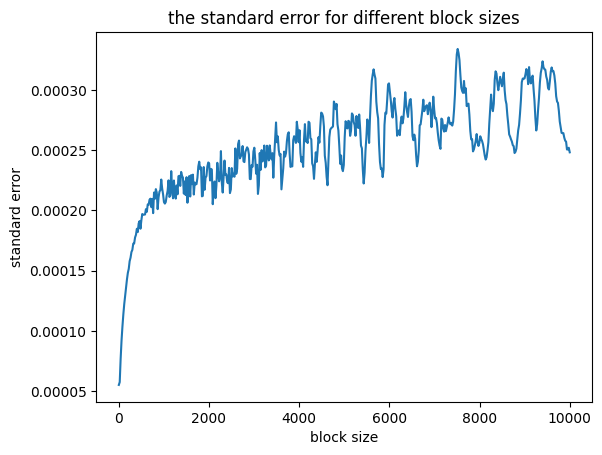

In [6]:
harmonic_block = Blocking(qmc_trace_harmonic.flatten(), harmonic_potential, 10000, block_gap=20)
bss, vars, means = harmonic_block.statistics()
plt.title('the standard error for different block sizes')
plt.xlabel('block size')
plt.ylabel('standard error')
plt.plot(bss, vars)
plt.show()

In [9]:
energies = np.array([harmonic_potential(qmc_trace_harmonic.flatten()[i].p) for i in range(len(qmc_trace_harmonic.flatten()))])
harmonic_mean = np.mean(energies)
std_err = np.sqrt(np.var(energies)/len(energies))
print(f'the average energy of harmonic potential is found to be {harmonic_mean} with standard error {std_err}')

the average energy of harmonic potential is found to be 0.030038248506541694 with standard error 5.528150435358175e-05
